# Association between stroke and psychosis across four nationally representative epidemiological studies

## Imputation of missing data in Collaborative Psychiatric Epidemiology Surveys 2001-2003 (United States) dataset using random forest imputation

In [16]:
# Load libraries
#
library(dplyr)
library(visdat)
library(missForest)

In [2]:
verbose_reporting <- FALSE
options(warn=-1)

### Loading and recoding of CPES dataset

In [3]:
# Load data
#
d1_filename <- "./Data/ICPSR_20240/DS0001/20240-0001-Data.tsv"
d3_filename <- "./Data/ICPSR_20240/DS0003/20240-0003-Data.tsv"

d1_df <- read.csv(d1_filename, sep="\t", header=T)
d3_df <- read.csv(d3_filename, sep="\t", header=T)

# Select variables
#
d1_select_df <- select(d1_df, 
                       caseid = CASEID, 
                       sex = V09036,
                       age = V07306)

d3_select_df <- select(d3_df, 
                       caseid = CASEID,
                       stroke = C10H,  # by medic
                       highest_ed = H13,
                       paranoia = PS1F, # Unjust plot to harm you/have people follow-nobody believe
                       hearvoices = PS1B,  # Ever hear voices others couldn't hear
                       thoughtpass = PS1C) # Ever have mind control experience

# Merge datasets 
#
dataset_cpes <- merge(d1_select_df, d3_select_df, by="caseid")

# Label dataset
#
dataset_cpes$dataset_name <- 'cpes'

# Recode stroke variable
#
dataset_cpes$stroke[dataset_cpes$stroke == 1 ] <- 1
dataset_cpes$stroke[dataset_cpes$stroke == 5 ] <- 0
dataset_cpes$stroke[dataset_cpes$stroke == -8 ] <- 0
dataset_cpes$stroke[dataset_cpes$stroke == -9 ] <- 0
dataset_cpes$stroke <- factor(dataset_cpes$stroke, levels = c(1,0), labels = c(" yes", " no")) 

# Recode psychotic symptom variables
#
dataset_cpes$paranoia[dataset_cpes$paranoia == 1 ] <- 1
dataset_cpes$paranoia[dataset_cpes$paranoia == 5 ] <- 0
dataset_cpes$paranoia[dataset_cpes$paranoia == -8 ] <- 0
dataset_cpes$paranoia[dataset_cpes$paranoia == -9 ] <- 0

dataset_cpes$hearvoices[dataset_cpes$hearvoices == 1 ] <- 1
dataset_cpes$hearvoices[dataset_cpes$hearvoices == 5 ] <- 0
dataset_cpes$hearvoices[dataset_cpes$hearvoices == -8 ] <- 0
dataset_cpes$hearvoices[dataset_cpes$hearvoices == -9 ] <- 0

dataset_cpes$thoughtpass[dataset_cpes$thoughtpass == 1 ] <- 1
dataset_cpes$thoughtpass[dataset_cpes$thoughtpass == 5 ] <- 0
dataset_cpes$thoughtpass[dataset_cpes$thoughtpass == -8 ] <- 0
dataset_cpes$thoughtpass[dataset_cpes$thoughtpass == -9 ] <- 0

# Calculate probable psychosis variable
#
dataset_cpes$psychosis_tot <- rowSums(dataset_cpes[,c("paranoia", "hearvoices", "thoughtpass")], na.rm=TRUE)
dataset_cpes$prob_psychosis[dataset_cpes$psychosis_tot >= 2] <- 1
dataset_cpes$prob_psychosis[dataset_cpes$psychosis_tot <= 1] <- 0
dataset_cpes$psychosis_tot <- NULL

# Set types for psychosis variables
dataset_cpes$paranoia <- factor(dataset_cpes$paranoia, levels = c(1,0), labels = c(" yes", " no")) 
dataset_cpes$hearvoices <- factor(dataset_cpes$hearvoices, levels = c(1,0), labels = c(" yes", " no")) 
dataset_cpes$thoughtpass <- factor(dataset_cpes$thoughtpass, levels = c(1,0), labels = c(" yes", " no")) 
dataset_cpes$prob_psychosis <- factor(dataset_cpes$prob_psychosis, levels = c(1,0), labels = c(" yes", " no")) 

# Highest level of education
#
dataset_cpes$highest_ed[dataset_cpes$highest_ed <= 9] <- 1 # Basic
dataset_cpes$highest_ed[dataset_cpes$highest_ed==10] <- 2  # Mid teen high school
dataset_cpes$highest_ed[dataset_cpes$highest_ed==11] <- 2  # Mid teen high school
dataset_cpes$highest_ed[dataset_cpes$highest_ed==12] <- 3  # Late teen high school
dataset_cpes$highest_ed[dataset_cpes$highest_ed==13] <- 3  # Late teen high school 
dataset_cpes$highest_ed[dataset_cpes$highest_ed==14] <- 3  # Late teen high school 
dataset_cpes$highest_ed[dataset_cpes$highest_ed==15] <- 3  # Late teen high school 
dataset_cpes$highest_ed[dataset_cpes$highest_ed==16] <- 4  # College / uni
dataset_cpes$highest_ed[dataset_cpes$highest_ed==17] <- 4  # College / uni

dataset_cpes$highest_ed <- factor(dataset_cpes$highest_ed,
                                  levels = c(1, 2, 3, 4),
                                  labels = c("No / primary education", "Mid-teen high school", "Late teen high school", "College / university")) 

# Sex
dataset_cpes$sex <- factor(dataset_cpes$sex,
                           levels = c(1,2),
                           labels = c(" male", " female")) 

### Display number of missing variables (NAs) in...

Paranoia variable

In [4]:
table(dataset_cpes$paranoia, useNA = "always")


 yes   no <NA> 
  68 4926 1088 

Hallucinated voices variable

In [5]:
table(dataset_cpes$hearvoices, useNA = "always")


 yes   no <NA> 
 293 4702 1087 

Thought passivity delusion variable

In [6]:
table(dataset_cpes$thoughtpass, useNA = "always")


 yes   no <NA> 
  33 4962 1087 

### Create CPES dataset with predictor variables from original dataset alongside psychotic symptoms

In [7]:
d3_for_imputation <- select(d3_df,
                            caseid = CASEID,
                            NEWROLEIMPSCORE, A5, B3, C15, SC31, SC32, FH3D, FH3E, FH3G, FH3H, FH3I, FH3J,
                            FH3K, FH3L, OBESE6CAT, K81, K10, K15, K16A, K16B, K16C, K16D, K16E, K16F, K16G,
                            K16H, K16I, K16J, K19A, K19B, K19C, K19D, K19H, D_ALAH12, B4, B5, B6, B8, B10,
                            B11, B12, B14A, B14B, B14C, B15A, B15C, CG50A, CG50B, CG50C, CG50D, CG50E, C4,
                            C5, C6, C7A, C7B, C7C, C7D, C7F, C7G, C21A, C29A, C29E, C29G, C29K, C29L, C30,
                            C32, C34, C36, E12A, SC26_3, SC26_4, SU1, SU41, SU42, SU43, SU44, PH1, PH2,
                            PH2_1A, PH2_1B, PH2_1C, PH2_1D, PH2_1E, PEA40, PEA41, PEA42, PEA43, PEA44,
                            PEA45, PEA46, PEA47, PEA48, PEA49, PEA50, PEA51, PEA52, PEA53, PEA54, PEA55,
                            PEA56, PEA57, PEA58, PEA59, PEA61, PEA62, PEA63, PEA64, PEA65, PEA66, PEA67,
                            PEA68, PEA69, PEA70, PEA71, PEA72, PEA73, PEA74, PEA75, PEA76, PEA77, PEA78,
                            PEA79, PEA81, PEA82, PEA83, NSD2A, NSD2B, NSD2C, NSD2D, NSD2E, NSD2F, NSD2G,
                            TB1, EA1, EA16, O1, O2, O9, O10, O11, O12, PS1A, PS1B, PS1C, PS1D, PS1E, PS1F,
                            GM1, FH3A, FH3B, FH3C, FH3F, SR10, SR11, SR128, SR131, F2, G1, G2, G4A, G4B, G4C,
                            G4D, G4E, G4F, G4G, G4H, G10A, G10B, G11, H7A, H10, SR13, DSM_ALA, DSM_ALD,
                            DSM_ALAH, DSM_DRA, DSM_DRD, DSM_PTS, DSM_ANO, DSM_BUL, DSM_BULH, DSM_BINGEH,
                            DSM_BINGEANY, DSM_SAD, DSM_ASA, D_ALA12, D_ALD12, D_DRA12, D_DRAH12, D_DRD12,
                            D_PTS12, D_ANO12, D_BUL12, D_BULH12, D_BINGEH12, D_BINGEANY12, D_ASA12, D_ALA30,
                            D_ALAH30, D_ALD30, D_DRA30, D_DRAH30, D_DRD30, D_ANO30, D_BUL30, D_BULH30, D_BINGEH30,
                            D_BINGEANY30, D_ASA30, ICD_ALA, ICD_ALD, ICD_ALAH, ICD_DRA, ICD_DRD, ICD_ANO, ICD_ANOH,
                            ICD_BUL, I_ALA12, I_ALD12, I_ALAH12, I_DRA12, I_DRD12, I_ANO12, I_ANOH12, I_BUL12,
                            I_ALA30, I_ALD30, I_ALAH30, I_DRA30, I_DRD30, I_ANO30, I_ANOH30, I_BUL30,
                            PS1F, PS1B, PS1C)

# Merge datasets
#
dataset_cpes_for_imputation <- merge(d1_select_df, d3_for_imputation, by="caseid")

# Remove Case ID as predictor
#
dataset_cpes_for_imputation$caseid <- NULL

# Change coding of psychotic symptom variables to match coding in our final analysis dataset
dataset_cpes_for_imputation$PS1F[dataset_cpes_for_imputation$PS1F == 1 ] <- 1
dataset_cpes_for_imputation$PS1F[dataset_cpes_for_imputation$PS1F == 5 ] <- 0
dataset_cpes_for_imputation$PS1F[dataset_cpes_for_imputation$PS1F == -8 ] <- 0
dataset_cpes_for_imputation$PS1F[dataset_cpes_for_imputation$PS1F == -9 ] <- 0

dataset_cpes_for_imputation$PS1B[dataset_cpes_for_imputation$PS1B == 1 ] <- 1
dataset_cpes_for_imputation$PS1B[dataset_cpes_for_imputation$PS1B == 5 ] <- 0
dataset_cpes_for_imputation$PS1B[dataset_cpes_for_imputation$PS1B == -8 ] <- 0
dataset_cpes_for_imputation$PS1B[dataset_cpes_for_imputation$PS1B == -9 ] <- 0

dataset_cpes_for_imputation$PS1C[dataset_cpes_for_imputation$PS1C == 1 ] <- 1
dataset_cpes_for_imputation$PS1C[dataset_cpes_for_imputation$PS1C == 5 ] <- 0
dataset_cpes_for_imputation$PS1C[dataset_cpes_for_imputation$PS1C == -8 ] <- 0
dataset_cpes_for_imputation$PS1C[dataset_cpes_for_imputation$PS1C == -9 ] <- 0

# Change to factor type to ensure they're imputed as factors
dataset_cpes_for_imputation$PS1F <- as.factor(dataset_cpes_for_imputation$PS1F)
dataset_cpes_for_imputation$PS1B <- as.factor(dataset_cpes_for_imputation$PS1B)
dataset_cpes_for_imputation$PS1C <- as.factor(dataset_cpes_for_imputation$PS1C)

### Display map of missing data over dataset being used to impute psychotic symptom variables

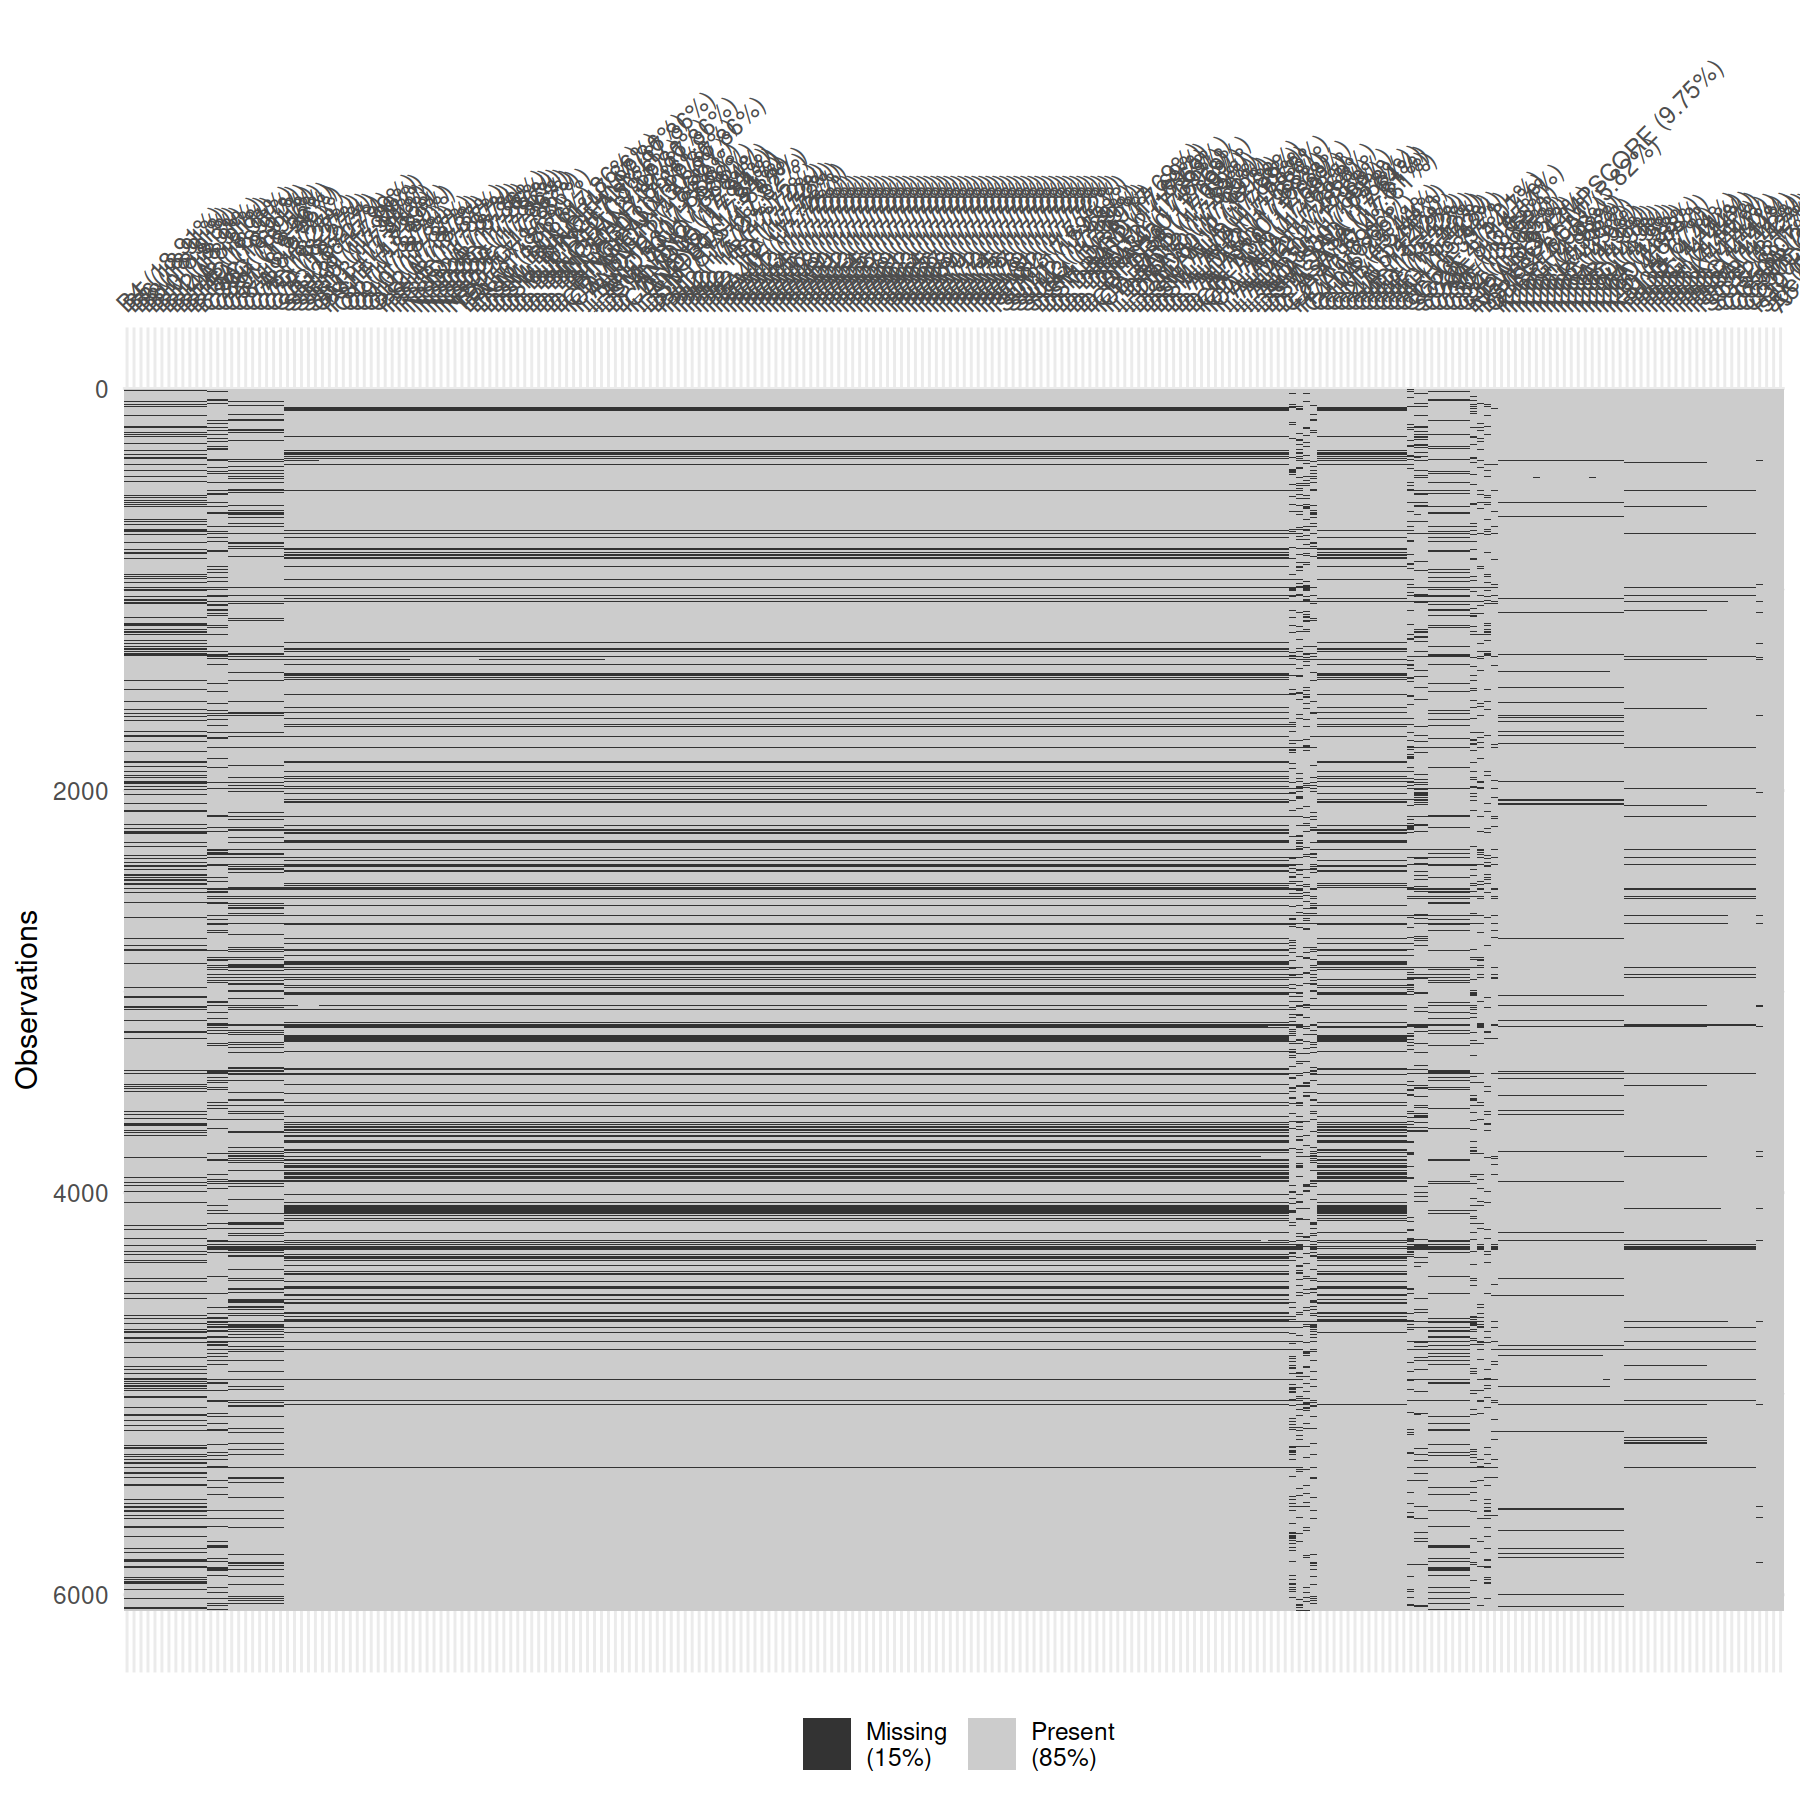

In [8]:
options(repr.plot.width = 9, repr.plot.height = 9, repr.plot.res = 200)
vis_miss(dataset_cpes_for_imputation, sort_miss = TRUE, warn_large_data = FALSE)

### Impute missing data using random forest imputation

This is very computationally intensive! May take several hours.

In [9]:
set.seed(31415926)

d3_df.imp <- missForest(dataset_cpes_for_imputation)

d3_imputed_df <- select(d3_df.imp$ximp,
                        paranoia = PS1F,
                        hearvoices = PS1B,  
                        thoughtpass = PS1C)

d3_imputed_df$paranoia <- factor(d3_imputed_df$paranoia, levels = c(1,0), labels = c(" yes", " no")) 
d3_imputed_df$hearvoices <- factor(d3_imputed_df$hearvoices, levels = c(1,0), labels = c(" yes", " no")) 
d3_imputed_df$thoughtpass <- factor(d3_imputed_df$thoughtpass, levels = c(1,0), labels = c(" yes", " no")) 

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!


### Show that no new symptoms were imputed by comparison with original dataset (all NAs are zeros)

In [10]:
table(dataset_cpes$paranoia, useNA="always")
table(d3_imputed_df$paranoia, useNA="always")

table(dataset_cpes$hearvoices, useNA="always")
table(d3_imputed_df$hearvoices, useNA="always")

table(dataset_cpes$thoughtpass, useNA="always")
table(d3_imputed_df$thoughtpass, useNA="always")


 yes   no <NA> 
  68 4926 1088 


 yes   no <NA> 
  68 6014    0 


 yes   no <NA> 
 293 4702 1087 


 yes   no <NA> 
 293 5789    0 


 yes   no <NA> 
  33 4962 1087 


 yes   no <NA> 
  33 6049    0 

### Analysis platform details and software versions

In [11]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          0.3                         
year           2020                        
month          10                          
day            10                          
svn rev        79318                       
language       R                           
version.string R version 4.0.3 (2020-10-10)
nickname       Bunny-Wunnies Freak Out     

In [12]:
packageVersion("dplyr")

[1] ‘1.0.7’

In [13]:
packageVersion("visdat")

[1] ‘0.5.3’

In [15]:
packageVersion("missForest")

[1] ‘1.4’